In [4]:
import pandas as pd
from pylab import *
from scipy.spatial import cKDTree
import torch
from integrator.io import StillData, RotationData
import matplotlib.pyplot as plt
import numpy as np
from integrator.models import MLP
import reciprocalspaceship as rs
import integrator

# Maximum Likelihood Integrator

The idea of this model is to integrate pixel information using a maximum likelihood model. 
The model is cast as $p(\text{intensity} | \text{background}, \text{pixel vals})$.

# Data Processing

Image files have an `.mccd` extension.
Spot prediction files have an `.mccd.ii` extension.

In [5]:
image_file = "e080_001.mccd"
prediction_file = "e080_001.mccd.ii"

In [6]:
#maximum number of pixels considered for each reflection
max_size = 1024
img_data = StillData([image_file], [prediction_file], max_size=max_size)


In [7]:
# Predicted spot dataset
# DataFrame of each reflection and its metadata
img_data.get_data_set(0)

,X,Y,H,K,L,Multiplicity,Resolution,Wavelength,I,SigI
0,66.5,2149.0,10,15,49,1,1.509,1.0449173,8.5,17.65
1,75.6,2259.1,11,15,47,1,1.5121,1.0487897,4.22,17.76
2,122.7,1679.4,5,14,53,1,1.5748,1.0737404,10.22,17.36
3,161.7,1970.0,8,14,50,1,1.5719,1.0480704,6.12,15.46
4,177.0,1678.8,5,14,54,1,1.5538,1.0387537,8.25,19.18
...,...,...,...,...,...,...,...,...,...,...
1683,3796.4,1558.6,-13,5,-48,1,1.5978,1.0733105,11.65,19.85
1684,3810.1,2080.4,-8,5,-56,1,1.6061,1.0678645,2.18,15.77
1685,3821.8,1985.1,-9,5,-55,1,1.5998,1.0669236,8.65,15.14
1686,3822.2,1890.1,-10,5,-54,1,1.5897,1.0608653,5.29,16.13


In [8]:
# Read image
pix = imread(image_file)

#predicted spots and metadata
x_coords = img_data.get_data_set(0)['X'].to_numpy('float32')
y_coords = img_data.get_data_set(0)['Y'].to_numpy('float32')


xy = np.column_stack((x_coords,y_coords)) #centroids
pxy = np.indices(pix.shape).T.reshape((-1,2)) #reshapes into 2-d array of indices

# For all pixels, find nearest reflection
tree = cKDTree(xy)
d,pidx = tree.query(pxy) 

#Distance between pixel and nearest reflection
dxy = pxy - xy[pidx]
""" 
pidx = pidx.reshape(pix.shape)
edges = np.zeros_like(pidx,dtype='bool')
for i in [0,0,1]:
    for j in [-1,0,1]:
     edges = I = np.roll(np.roll(pidx,i,0),j,1) != pidx
pix_with_edges = pix.copy()
pix_with_edges[edges] =pix.max()

 """

" \npidx = pidx.reshape(pix.shape)\nedges = np.zeros_like(pidx,dtype='bool')\nfor i in [0,0,1]:\n    for j in [-1,0,1]:\n     edges = I = np.roll(np.roll(pidx,i,0),j,1) != pidx\npix_with_edges = pix.copy()\npix_with_edges[edges] =pix.max()\n\n "

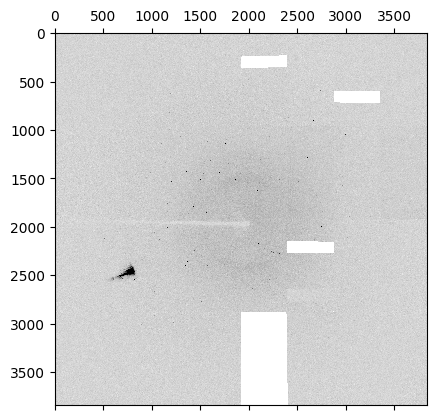

In [9]:
plt.matshow(pix,vmin=1,vmax=55,cmap='gray_r')

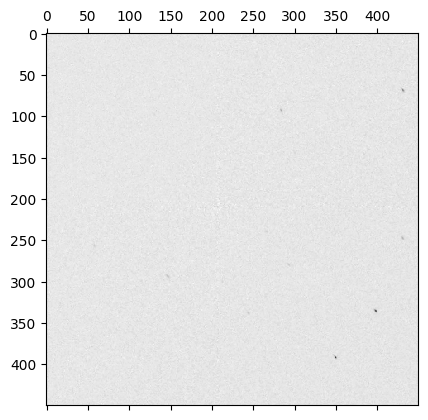

In [10]:
plt.matshow(pix[750:1200,750:1200],vmin=1.,vmax=100.,cmap='gray_r')

In [11]:
df = pd.DataFrame(
                {
                "counts": pix.flatten(),
                "dist": d,  # distance between pixel and nearest centroid
                "x": pxy[:, 0],  # pixel x-coord
                "y": pxy[:, 1],  # pixel y-coord
                "dx": dxy[:, 0],  # distance between pixel x-coord and centroid x-coord
                "dy": dxy[:, 1],  # distance between pixel y-coord and centroid y-coord
                "idx": pidx,  # nearest neighbor index
    }
)
df

,counts,dist,x,y,dx,dy,idx
0,0,889.998417,0,0,-573.599976,-680.500000,97
1,10,889.354250,1,0,-572.599976,-680.500000,97
2,10,888.710742,2,0,-571.599976,-680.500000,97
3,10,888.067893,3,0,-570.599976,-680.500000,97
4,10,887.425705,4,0,-569.599976,-680.500000,97
...,...,...,...,...,...,...,...
14745595,10,816.875875,3835,3839,613.899902,538.899902,1481
14745596,10,817.627663,3836,3839,614.899902,538.899902,1481
14745597,10,818.379982,3837,3839,615.899902,538.899902,1481
14745598,10,819.132831,3838,3839,616.899902,538.899902,1481


The following code groups the `idx` and `dist` columns by `idx`, and then takes the top 1024 pixels.
This results in a patch of pixels that contain a centroid.

In [12]:
#Adding dist_rank column
df["dist_rank"] = (df[["idx","dist"]].groupby("idx").rank(method="first").astype("int") - 1 )

#Max size of patch
m = max_size

#Number of spots
n = len(xy) 

#Return dataframe with m pixels per reflection
df = df[df.dist_rank < m]


In [13]:
#Index of each pixel
idx1,idx2 = df.idx.to_numpy(),df.dist_rank.to_numpy()

#Create mask
mask = torch.zeros((n,m),dtype=torch.bool)
mask[idx1,idx2] = True


In [14]:
#Process a diffraction image
xy_idx, xy,dxy,counts,mask= img_data[0]

In [15]:
d = xy_idx.shape[-1]
xy_idx[0][0,0], xy_idx[1][0,0]
xy

tensor([[[-1.9801e+00,  2.6599e-01],
         [-1.9790e+00,  2.6599e-01],
         [-1.9801e+00,  2.6492e-01],
         ...,
         [-1.9780e+00,  2.4673e-01],
         [-1.9935e+00,  2.5315e-01],
         [-1.9656e+00,  2.5315e-01]],

        [[-1.9698e+00,  3.8371e-01],
         [-1.9708e+00,  3.8371e-01],
         [-1.9698e+00,  3.8478e-01],
         ...,
         [-1.9677e+00,  4.0298e-01],
         [-1.9553e+00,  3.9548e-01],
         [-1.9863e+00,  3.7408e-01]],

        [[-1.9212e+00, -2.3698e-01],
         [-1.9212e+00, -2.3591e-01],
         [-1.9222e+00, -2.3698e-01],
         ...,
         [-1.9047e+00, -2.2842e-01],
         [-1.9119e+00, -2.5303e-01],
         [-1.9367e+00, -2.4768e-01]],

        ...,

        [[ 1.8988e+00,  9.0488e-02],
         [ 1.8977e+00,  9.0488e-02],
         [ 1.8988e+00,  9.1558e-02],
         ...,
         [ 1.8802e+00,  9.3698e-02],
         [ 1.8926e+00,  7.2295e-02],
         [ 1.9091e+00,  1.0654e-01]],

        [[ 1.8988e+00, -1.1178e-02

Text(0, 0.5, 'y-pixel')

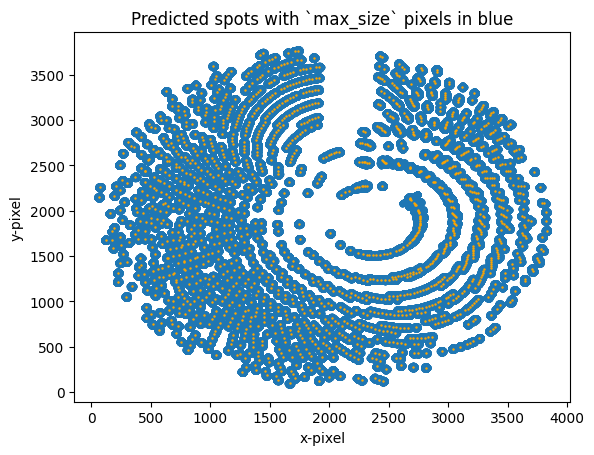

In [16]:
#areas surrounding spots
plt.plot(df.x,df.y,'.')
plt.title('Pixels around spots')

#predicted spots and metadata
x_coords = img_data.get_data_set(0)['X']
y_coords = img_data.get_data_set(0)['Y']

plt.plot(x_coords,y_coords,'.',markersize=1.5,color = 'orange')
plt.title('Predicted spots with `max_size` pixels in blue')
plt.xlabel('x-pixel')
plt.ylabel('y-pixel')

Text(0.5, 1.0, 'Vicinity around centroid of predicted reflection')

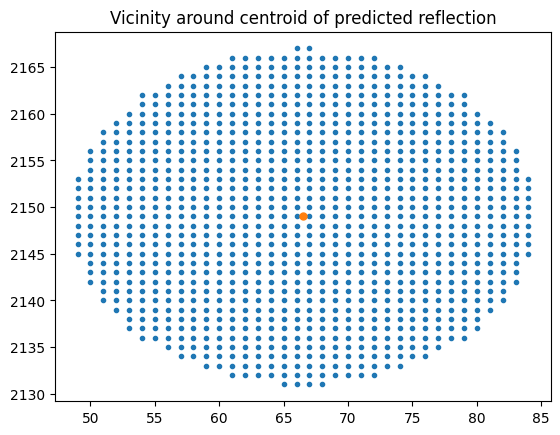

In [17]:
x = df[df.idx == 0].x.to_numpy()
y = df[df.idx == 0].y.to_numpy()


plt.plot(x,y,'.')
plt.plot(66.5,2149,'.',markersize=10,label='centroid')
plt.title('Vicinity around centroid of predicted reflection')


`counts` has dimensions $n \times m$, where $n$ is the number of predicted centroids (length of `xy`), and $m$ is equal to `max_size`. 

Each row in the arrays returned by `StillData` corresponds to a reflection.
Each column represents a pixel in the vicinity of a predicted reflection.
The maximum size of the vicinity is defined by the user, and stored in the variable `m`.


# Integrator

The `Integrator` class takes as input the `EllipticalProfile`, `MLPEncoder`, and `PoissonLikelihood` class. 
In this section we will cover each input and then see how the integrator ties it all together. 

## EllipticalProfile



### Residual layers

Network accuracy degrades with the increasing depth of a neural network. 
This problem is known as _degradation_. 
If accuracy degradation was due to overfitting, then the test accuracy would continue to increase, while the test accuracy decreases. 
However, this is not the case.
Instead, it has been observed that the training accuracy decreases as the depth increases (e.g there is a higher training error).
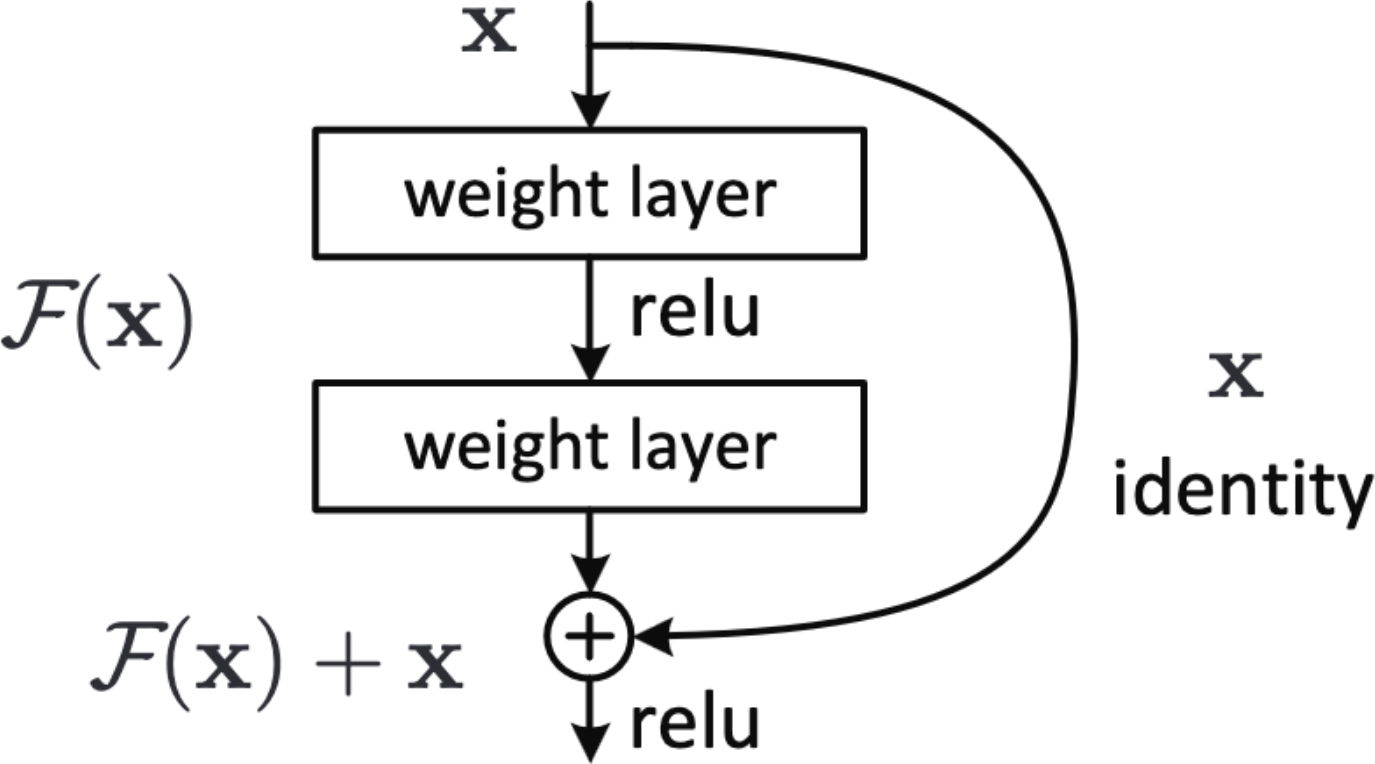





### Intensity sigma


In [18]:
batch_size = 100
I,SigI = [],[]

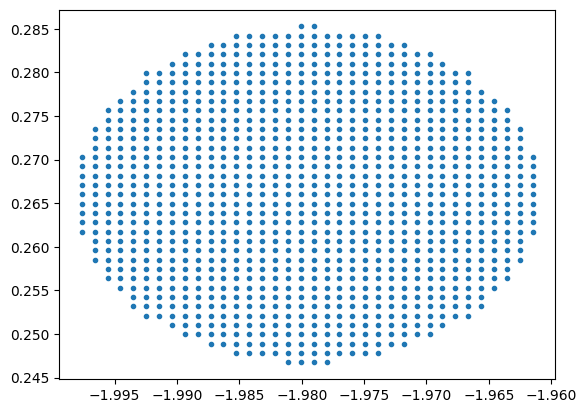

In [19]:
x1 = xy[:,:,0][0]
x2 = xy[:,:,1][0]

plt.plot(x1,x2,'.')

## Integrator class

Takes as input `encoder`, `profile`, and `likelihood`.


In [20]:
#splits xy into chunks of batch_size=100
batch_size=100
torch.split(xy,batch_size,dim=0)
torch.split(dxy,batch_size,dim=0)


(tensor([[[-0.0528, -0.0028],
          [ 0.0478, -0.0028],
          [-0.0528, -0.1061],
          ...,
          [ 0.1485, -1.8610],
          [-1.3609, -1.2416],
          [ 1.3560, -1.2416]],
 
         [[ 0.0378, -0.0132],
          [-0.0628, -0.0132],
          [ 0.0378,  0.0901],
          ...,
          [ 0.2390,  1.8450],
          [ 1.4465,  1.1224],
          [-1.5722, -0.9422]],
 
         [[ 0.0277, -0.0441],
          [ 0.0277,  0.0591],
          [-0.0729, -0.0441],
          ...,
          [ 1.6377,  0.7817],
          [ 0.9333, -1.5926],
          [-1.4817, -1.0764]],
 
         ...,
 
         [[ 0.0378, -0.0544],
          [ 0.0378,  0.0488],
          [-0.0628, -0.0544],
          ...,
          [-1.4716,  1.0811],
          [ 1.6478, -0.7771],
          [ 1.6478,  0.7714]],
 
         [[-0.0025, -0.0028],
          [-0.0025, -0.1061],
          [-0.1031, -0.0028],
          ...,
          [-1.8137,  0.1004],
          [ 1.8088,  0.1004],
          [-1.7131,  0.6165

In [21]:
depth = 10
dmodel = 64

In [22]:
integrator.models.encoder.MLP(dmodel,depth,d_in=5,output_dims=dmodel + 2)

MLP(
  (main): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ResidualLayer(
      (linear_1): Linear(in_features=64, out_features=128, bias=True)
      (linear_2): Linear(in_features=128, out_features=64, bias=True)
    )
    (2): ResidualLayer(
      (linear_1): Linear(in_features=64, out_features=128, bias=True)
      (linear_2): Linear(in_features=128, out_features=64, bias=True)
    )
    (3): ResidualLayer(
      (linear_1): Linear(in_features=64, out_features=128, bias=True)
      (linear_2): Linear(in_features=128, out_features=64, bias=True)
    )
    (4): ResidualLayer(
      (linear_1): Linear(in_features=64, out_features=128, bias=True)
      (linear_2): Linear(in_features=128, out_features=64, bias=True)
    )
    (5): ResidualLayer(
      (linear_1): Linear(in_features=64, out_features=128, bias=True)
      (linear_2): Linear(in_features=128, out_features=64, bias=True)
    )
    (6): ResidualLayer(
      (linear_1): Linear(in_features=64,

In [23]:
per_pix = torch.concat((xy,dxy,counts[...,None]),axis=-1)

In [24]:
#Get per spot normalization
def get_per_spot_normalization( counts, mask=None):
    if mask is None:
        return counts.mean(-1, keepdims=True) 
    return counts.sum(-1, keepdims=True) / mask.sum(-1, keepdims=True)

In [25]:
norm_factor = get_per_spot_normalization(counts,mask=None)

In [26]:
encoder = integrator.models.encoder.MLPEncoder(depth,dmodel)
encoder(xy,dxy,counts,mask)

(tensor([[[-0.0284,  0.0115,  0.0434,  ...,  0.1126, -0.3568, -0.2172]],
 
         [[-0.0272,  0.0121,  0.0414,  ...,  0.1145, -0.3570, -0.2176]],
 
         [[-0.0325,  0.0095,  0.0507,  ...,  0.1042, -0.3534, -0.2154]],
 
         ...,
 
         [[-0.0194, -0.0302, -0.0324,  ...,  0.1368, -0.3723, -0.2597]],
 
         [[-0.0249, -0.0324, -0.0295,  ...,  0.1548, -0.4316, -0.2987]],
 
         [[-0.0257, -0.0329, -0.0289,  ...,  0.1463, -0.3995, -0.2807]]],
        grad_fn=<UnsafeViewBackward0>),
 tensor([[[ 0.0072, -0.0209],
          [ 0.0065, -0.0204],
          [ 0.0082, -0.0218],
          ...,
          [ 0.0306, -0.0488],
          [ 0.0345, -0.0473],
          [ 0.0117, -0.0310]],
 
         [[ 0.0069, -0.0183],
          [ 0.0072, -0.0181],
          [ 0.0045, -0.0152],
          ...,
          [-0.0206,  0.0122],
          [-0.0197,  0.0070],
          [ 0.0326, -0.0413]],
 
         [[ 0.0035, -0.0259],
          [ 0.0015, -0.0236],
          [ 0.0052, -0.0278],
         

In [27]:
#Input dimension
d_in = 5
width = 64
depth = 10
output_dims = dmodel + 1
linear = integrator.layers.Linear(d_in,width)

#Linear layer
net = torch.nn.Sequential(linear)


In [28]:
class MLP_test(torch.nn.Module):
    def __init__(self,width,depth,d_in=None,output_dims = None):
        super().__init__()
        layers = [] 
        if d_in is not None: 
            layers.append(
                integrator.layers.Linear(d_in,width)
            )
        layers.extend(
            [integrator.layers.ResidualLayer(width) for i in range (depth)]
        )
        if output_dims is not None: 
            layers.append(integrator.layers.Linear(width,
                                 output_dims))
        self.main = torch.nn.Sequential(*layers)
    def forward(self,data,**kwargs):
        out = self.main(data)
        return out
    
class MLP_test_encoder(torch.nn.Module):
    def __init__(self,depth,dmodel,d_in=5):
        super().__init__()
        self.mlp_1 = MLP_test(dmodel,depth,d_in=d_in,output_dims=dmodel + 2)
    def forward(self,xy,dxy,counts,mask=None):
        per_pixel = torch.concat((
            xy,
            dxy,
            counts[...,None],
        ), axis = -1)
        out = self.mlp_1(per_pixel)
        return out

In [38]:
#Encoder class
encoder = MLP_test_encoder(depth,dmodel)

#Encoded input
encoder_out = encoder(xy,dxy,counts/norm_factor,mask)
encoder_out[...,:2].shape

tensor([[[-0.0642, -0.0183],
         [-0.0637, -0.0197],
         [-0.0657, -0.0165],
         ...,
         [-0.0849, -0.0138],
         [-0.0829,  0.0038],
         [-0.0754, -0.0290]],

        [[-0.0637, -0.0176],
         [-0.0646, -0.0147],
         [-0.0635, -0.0151],
         ...,
         [-0.0457, -0.0251],
         [-0.0474, -0.0401],
         [-0.0801,  0.0065]],

        [[-0.0641, -0.0191],
         [-0.0636, -0.0178],
         [-0.0636, -0.0205],
         ...,
         [-0.0514, -0.0418],
         [-0.0768, -0.0297],
         [-0.0815,  0.0042]],

        ...,

        [[ 0.0674, -0.0076],
         [ 0.0673, -0.0078],
         [ 0.0681, -0.0070],
         ...,
         [ 0.0638,  0.0108],
         [ 0.0481,  0.0091],
         [ 0.0864, -0.0302]],

        [[ 0.0677, -0.0103],
         [ 0.0678, -0.0103],
         [ 0.0679, -0.0075],
         ...,
         [ 0.0490,  0.0004],
         [ 0.0860, -0.0263],
         [ 0.0837, -0.0385]],

        [[ 0.0671, -0.0086],
       

In [39]:
encoder_out[...,:2

torch.Size([1688, 1024, 2])

In [36]:
torch.nn.functional.softmax(encoder_out[...,1:2].permute(2,0,1))
torch.special.expit(encoder_out[...,1:2].permute(2,0,1))

/var/folders/4x/2rft4dq177799_v2lctly2wm0000gn/T/ipykernel_11823/24346622.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.softmax(encoder_out[...,1:2].permute(2,0,1))


tensor([[[0.4972, 0.4972, 0.4968,  ..., 0.4918, 0.4934, 0.4936],
         [0.4971, 0.4971, 0.4975,  ..., 0.5032, 0.5007, 0.4943],
         [0.4972, 0.4976, 0.4972,  ..., 0.5002, 0.4928, 0.4941],
         ...,
         [0.5023, 0.5024, 0.5027,  ..., 0.5045, 0.4963, 0.5076],
         [0.5024, 0.5023, 0.5027,  ..., 0.4957, 0.5098, 0.5046],
         [0.5024, 0.5027, 0.5024,  ..., 0.5110, 0.4981, 0.5109]]],
       grad_fn=<SigmoidBackward0>)

In [31]:
encoder_out[...,1:2].permute(2,0,1)

tensor([[[-0.0114, -0.0113, -0.0127,  ..., -0.0327, -0.0262, -0.0256],
         [-0.0115, -0.0116, -0.0102,  ...,  0.0127,  0.0027, -0.0227],
         [-0.0110, -0.0097, -0.0111,  ...,  0.0009, -0.0287, -0.0235],
         ...,
         [ 0.0091,  0.0096,  0.0106,  ...,  0.0181, -0.0147,  0.0304],
         [ 0.0096,  0.0092,  0.0110,  ..., -0.0171,  0.0393,  0.0186],
         [ 0.0094,  0.0109,  0.0097,  ...,  0.0441, -0.0076,  0.0438]]],
       grad_fn=<PermuteBackward0>)

In [43]:
p = encoder_out[...,1:2]


tensor([[[-0.0183, -0.0197, -0.0165,  ..., -0.0138,  0.0038, -0.0290],
         [-0.0176, -0.0147, -0.0151,  ..., -0.0251, -0.0401,  0.0065],
         [-0.0191, -0.0178, -0.0205,  ..., -0.0418, -0.0297,  0.0042],
         ...,
         [-0.0076, -0.0078, -0.0070,  ...,  0.0108,  0.0091, -0.0302],
         [-0.0103, -0.0103, -0.0075,  ...,  0.0004, -0.0263, -0.0385],
         [-0.0086, -0.0068, -0.0099,  ..., -0.0057,  0.0163, -0.0256]]],
       grad_fn=<PermuteBackward0>)

In [46]:
encoder_out.shape
profile

NameError: name 'profile' is not defined

In [47]:
encoder_out[...,:1]

tensor([[[-0.0642],
         [-0.0637],
         [-0.0657],
         ...,
         [-0.0849],
         [-0.0829],
         [-0.0754]],

        [[-0.0637],
         [-0.0646],
         [-0.0635],
         ...,
         [-0.0457],
         [-0.0474],
         [-0.0801]],

        [[-0.0641],
         [-0.0636],
         [-0.0636],
         ...,
         [-0.0514],
         [-0.0768],
         [-0.0815]],

        ...,

        [[ 0.0674],
         [ 0.0673],
         [ 0.0681],
         ...,
         [ 0.0638],
         [ 0.0481],
         [ 0.0864]],

        [[ 0.0677],
         [ 0.0678],
         [ 0.0679],
         ...,
         [ 0.0490],
         [ 0.0860],
         [ 0.0837]],

        [[ 0.0671],
         [ 0.0675],
         [ 0.0673],
         ...,
         [ 0.0794],
         [ 0.0485],
         [ 0.0872]]], grad_fn=<SliceBackward0>)

In [48]:
encoder_out[...,1:2]

tensor([[[-0.0183],
         [-0.0197],
         [-0.0165],
         ...,
         [-0.0138],
         [ 0.0038],
         [-0.0290]],

        [[-0.0176],
         [-0.0147],
         [-0.0151],
         ...,
         [-0.0251],
         [-0.0401],
         [ 0.0065]],

        [[-0.0191],
         [-0.0178],
         [-0.0205],
         ...,
         [-0.0418],
         [-0.0297],
         [ 0.0042]],

        ...,

        [[-0.0076],
         [-0.0078],
         [-0.0070],
         ...,
         [ 0.0108],
         [ 0.0091],
         [-0.0302]],

        [[-0.0103],
         [-0.0103],
         [-0.0075],
         ...,
         [ 0.0004],
         [-0.0263],
         [-0.0385]],

        [[-0.0086],
         [-0.0068],
         [-0.0099],
         ...,
         [-0.0057],
         [ 0.0163],
         [-0.0256]]], grad_fn=<SliceBackward0>)

A single reflection is represented by a 1x1024x64 representation. 

In [49]:
#Separating score from reflection matrix
score = encoder_out[...,:1]
refl = encoder_out[...,1:]
print(f"Shape of score matrix: {score.shape}\nShape of refl matrix:{refl.shape}")

Shape of score matrix: torch.Size([1688, 1024, 1])
Shape of refl matrix:torch.Size([1688, 1024, 65])


In [50]:
score = torch.where(mask[...,None],score,-np.inf)

Softmax is calculated per reflection. 
Each pixel of each reflection gets a probabilistic score.

In [51]:
#Softmax 
score = torch.softmax(score,axis=-2)

In [52]:
representation = torch.matmul(score.transpose(-2,-1),refl)
representation.shape

torch.Size([1688, 1, 65])

In [53]:
lin2 = integrator.layers.Linear(dmodel,3 + 3 + 2 + 1 + 1)
lin2(representation)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1688x65 and 64x10)

In [ ]:
eps = 1e-12
beta = 10.


profile = integrator.models.EllipticalProfile(dmodel,eps = eps,beta = beta)
params = profile.get_params(representation)

NameError: name 'params' is not defined

The `.get_params` function returns a n x m matrix, where n is the number of reflections, and m is a concatenation of background, covariance, dxy, I, and sigI.

params

In [55]:
diag = torch.nn.functional.softplus(params[...,3:5],beta = beta) + eps
diag,diag.shape

NameError: name 'params' is not defined

In [56]:
L = (diag[:,None,:]* torch.eye(2)[None, ...])
L[...,1,0] = params[...,5] 
precision = torch.matmul(L,L.transpose(-1,-2)) #Each 2x2 is multiplied by its transpose
ddxy = params[...,6:8] #centroid offset

X = dxy - ddxy

TypeError: 'function' object is not subscriptable

In [57]:
L[0,...].transpose(-1,-2),L[0,...]


NameError: name 'L' is not defined

In [58]:
profile = torch.exp((-X[...,None,:] @ precision @ X[...,:,None] ))

NameError: name 'X' is not defined

In [59]:
profile = torch.squeeze(profile, dim=(-2, -1))
profile.shape


NameError: name 'profile' is not defined

In [60]:
m = params[...,:2]
b = params[...,2]
bg = (m * dxy).sum(-1) + b
bg = torch.nn.functional.softplus(bg,beta = beta) + eps

bg.shape

NameError: name 'params' is not defined

In [61]:
bg

NameError: name 'bg' is not defined

In [62]:
xy[0,:,0,...]


tensor([-1.9801, -1.9790, -1.9801,  ..., -1.9780, -1.9935, -1.9656])

Text(0.5, 0.92, 'Estimated background')

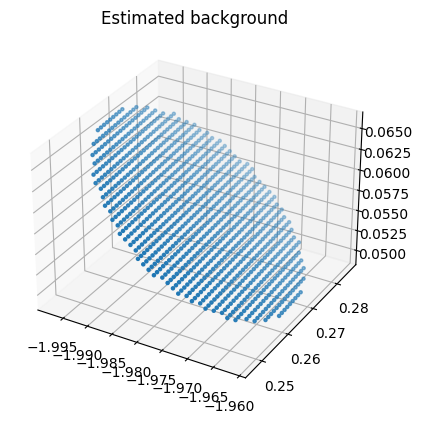

In [ ]:
ax = plt.figure().add_subplot(projection='3d')

x = xy[0,:,0,...]
y = xy[0,:,1,...]
z = bg[0,...].detach().numpy()

ax.scatter(x,y,zs=z,zdir='z',marker='.')
plt.title('Estimated background')


torch.Size([1688, 1024, 1])

In [ ]:
loc = params[...,-2]
scale = params[...,-1]
scale = torch.nn.functional.softplus(scale,beta=beta) + eps

q = torch.distributions.LogNormal(loc,scale)

loc.shape,scale.shape



(torch.Size([1688, 1]), torch.Size([1688, 1]))

The  `Integrator` class returns the negative loglikehood, our loss function.
The model optimizes the paramaters, `bg`, `cov`, `dxy`, `I`,  and `SigI`. 

TypeError: Image data of dtype <U15 cannot be converted to float

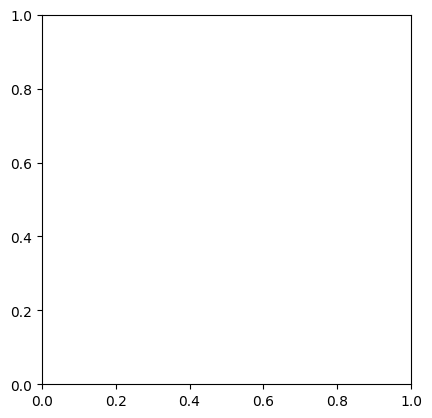

In [ ]:
plt.imshow('./e080_001.mccd')

In [ ]:
q.rsample([1024]) * encoder_out[...,1:2].permute(2,0,1)

tensor([[[-0.0246, -0.0269, -0.0232,  ..., -0.0113,  0.0196, -0.0475],
         [-0.0305, -0.0276, -0.0313,  ..., -0.0592, -0.0829,  0.0219],
         [-0.0197, -0.0207, -0.0177,  ..., -0.0747, -0.0284,  0.0325],
         ...,
         [ 0.0116,  0.0140,  0.0109,  ...,  0.0594,  0.0511, -0.0350],
         [ 0.0139,  0.0113,  0.0141,  ...,  0.0368, -0.0196, -0.0462],
         [ 0.0142,  0.0141,  0.0158,  ...,  0.0158,  0.0677, -0.0150]],

        [[-0.0292, -0.0321, -0.0275,  ..., -0.0135,  0.0233, -0.0565],
         [-0.0308, -0.0278, -0.0315,  ..., -0.0598, -0.0836,  0.0221],
         [-0.0202, -0.0212, -0.0181,  ..., -0.0764, -0.0291,  0.0332],
         ...,
         [ 0.0102,  0.0123,  0.0095,  ...,  0.0520,  0.0447, -0.0307],
         [ 0.0111,  0.0091,  0.0113,  ...,  0.0295, -0.0157, -0.0370],
         [ 0.0139,  0.0139,  0.0155,  ...,  0.0156,  0.0667, -0.0148]],

        [[-0.0243, -0.0267, -0.0229,  ..., -0.0112,  0.0194, -0.0470],
         [-0.0258, -0.0234, -0.0264,  ..., -0

In [ ]:
encoder_out[...,2:].shape

torch.Size([1688, 1024, 64])